In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.linear_model import LinearRegression
from src.utils import get_lags
from src.transformer import ForecastPipeline, MakingRowTransformer

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/home/marti/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import requests
import io

In [3]:
# https://datahub.io/core/global-temp
resp = requests.get('https://datahub.io/core/global-temp/r/monthly.csv')
dataset = pd.read_csv(io.BytesIO(resp.content)).sort_values(by=['Date'])

In [4]:
dataset.head()

,Source,Date,Mean
3287,GISTEMP,1880-01-06,-0.3000
3286,GCAG,1880-01-06,0.0009
3284,GCAG,1880-02-06,-0.1229
3285,GISTEMP,1880-02-06,-0.2100
3282,GCAG,1880-03-06,-0.1357


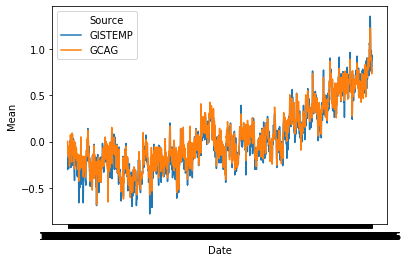

In [5]:
sns.lineplot(data=dataset, x='Date', y='Mean', hue='Source')

In [6]:
ts = dataset[dataset.Source=='GCAG'][['Date', 'Mean']]
ts.columns = ['time', 'y']
ts.time = ts.time.apply(pd.to_datetime)
ts = ts.set_index(['time'])
ts = ts.resample('1M').sum()

In [7]:
features = [
    (get_lags, (1*12,)),
    (get_lags, (2*12,)),
    (get_lags, (3*12,)),
    (get_lags, (4*12,)),
    (get_lags, (5*12,)),
    (get_lags, (6*12,)),
    (get_lags, (7*12,)),
    (get_lags, (8*12,)),
]

In [13]:
shift = 100
MR = MakingRowTransformer(features, shift=shift)

In [14]:

step = 1000
pipe = ForecastPipeline([
    ('MakingRowTransformer', MakingRowTransformer(features, shift=shift)), 
    ('LR', LinearRegression())
])
pipe = pipe.fit(ts.y.iloc[:step], ts.y.iloc[shift:step])

In [15]:
forecast = pipe.forecast(ts.y.iloc[:step], horizon=200)

In [16]:
to_merge = ts.copy()
to_merge['type'] = 'true'
ts_forecast = pd.DataFrame(forecast)
ts_forecast['type'] = 'forecast'
to_merge = pd.concat([to_merge, ts_forecast])

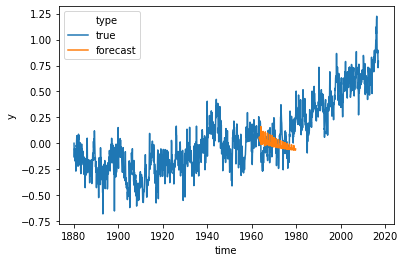

In [17]:
sns.lineplot(data=to_merge.reset_index(), x='time', y='y', hue='type')